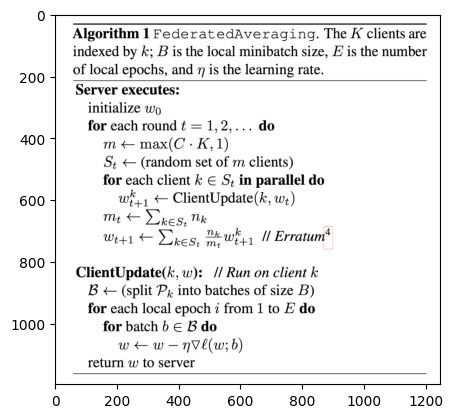

In [ ]:
# show the algorithm
import matplotlib.pyplot as plt

image_path = '/content/Screenshot 2023-11-28 at 6.27.29 PM.png'

X = plt.imread(image_path)
plt.imshow(X)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Both Server and Client use Torch-type model

class Server:
    # use a pretained base model for initial weights, such as falcon-7b
    # client_fraction we use 1 as default
    def __init__(self, initial_weights, num_clients, client_fraction=1):
        self.global_weights = initial_weights  # PyTorch state_dict
        self.client_fraction = client_fraction
        self.num_clients = num_clients # assuming each client has a unique index

    def select_clients(self):
        if self.client_fraction == 1:
            return list(range(self.num_clients))
        m = max(int(self.client_fraction * self.num_clients), 1)
        selected_clients = np.random.choice(self.num_clients, m, replace=False)
        return selected_clients

    def aggregate_updates(self, client_updates, client_data_counts):
        total_data_count = np.sum(client_data_counts)
        # Initialize a new state_dict for the aggregated weights
        aggregated_weights = {key: torch.zeros_like(val) for key, val in self.global_weights.items()}

        for client_weights, data_count in zip(client_updates, client_data_counts):
            for key in self.global_weights.keys():
                # Aggregate the weights for each layer
                aggregated_weights[key] += client_weights[key] * (data_count / total_data_count)

        self.global_weights = aggregated_weights

    def send_global_weights(self):
        return self.global_weights



In [ ]:
class Client:
    # data is a list of (x, y) pairs
    # initial_weights is a numpy array, could be a pretained language model weights
    def __init__(self, data_loader, model, epochs, learning_rate):
        self.data_loader = data_loader  # DataLoader object containing the client's data
        self.model = model  # PyTorch model
        self.epochs = epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def train(self):
        self.model.train()  # Set the model to training mode
        for epoch in range(self.epochs):
            for batch in self.data_loader:
                features, labels = batch
                self.optimizer.zero_grad()  # Clear gradients from the previous step
                outputs = self.model(features)
                loss = self.criterion(outputs, labels)
                loss.backward()  # Backpropagate the loss
                self.optimizer.step()  # Update the weights
        return self.model.state_dict()  # Return the updated model weights

    # Update the local model with the global model
    def update_local_model(self, global_weights):
        self.model.load_state_dict(global_weights)

    # for weighted avrage use
    def get_data_count(self):
        return len(self.data_loader)

### For simulaton purpose, we create a sentiment analysis model

In [ ]:
# Sentiment analysis model

class SentimentAnalysis(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SentimentAnalysis, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        pass